In [3]:
#read in packages to be used
using CSV
using DataFrames
using FASTX
using StatsPlots
using BioSequences
using Plots.Measures

#by default Jupyter Notebook will limit the number of rows and columns when displaying a data frame. Override this behavior by changing the values of the ENV["COLUMNS"]
ENV["COLUMNS"] = 400

400

In [4]:
#'reader' is a struct (an object) for reading .fasta files. Open() creates an IOStream which the FASTA.Reader will read from.
reader = FASTA.Reader(open("PP024676.fasta" , "r"))

#'record' is a struct for recording .fasta files. 
record = FASTA.Record()

#read and return
read!(reader, record)

#length of the sequence
genomelength = length(sequence(record)) - 1000
genome = sequence(record)[1:genomelength]
genomelength

363297

In [5]:
#the CSV package is creating a Table from the .gff file and the DataFrame package is creating a DataFrame from the Table.  
gff = DataFrame(CSV.File("PP024676.gff", delim="\t", comment ="#",
        header=["refID","chloe","type","start","end","score","strand","phase","annotation"]))
#print the first 6 rows of the DataFrame.
first(gff, 6)

6×9 DataFrame
 Row │ refID                            chloe     type      start  end    score    strand   phase    annotation                        
     │ String31                         String15  String31  Int64  Int64  String1  String1  String1  String                            
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Phylloglossum_drummondii_mt_1kb  Geneious  CDS        4441   4815  .        +        0        Name=rps12 CDS
   2 │ Phylloglossum_drummondii_mt_1kb  Geneious  gene       4441   4815  .        +        .        Name=rps12 gene
   3 │ Phylloglossum_drummondii_mt_1kb  Geneious  CDS        7505   7675  .        +        0        Name=cox3 CDS;ID=QqfPWJnHtKTHbPF…
   4 │ Phylloglossum_drummondii_mt_1kb  Geneious  CDS        8453   9079  .        +        0        Name=cox3 CDS;ID=QqfPWJnHtKTHbPF…
   5 │ Phylloglossum_drummondii_mt_1kb  Geneious  exon       7505   7675  .        +        .        Name=cox3 exon 1
   6 │ Phylloglossum_drummondii_mt_1kb  Geneious  gene       7505   9079  .        +        .        Name=cox3 gene

In [6]:
#the CSV package is creating a Table from the .gff file and the DataFrame package is creating a DataFrame from the Table. 
Ph1counts = DataFrame(CSV.File("Ph1_r_mt.counts.tsv", delim="\t", comment ="#"))

#drop the :total column from the DataFrame counts
Ph1counts = combine(Ph1counts, Not(:total))

#sum extension counts. 
#the first 1000 rows of the DataFrame, from the 4th column to the last column, added
#to the rows from (genomelength+1) to the last row of the DataFrame (last 1000 rows), from column 4 to the last column. 
Ph1counts[1:1000,4:end] .+= Ph1counts[genomelength + 1:end,4:end]

#remove 1 Kb overlap (last 1000)
deleteat!(Ph1counts, genomelength + 1:nrow(Ph1counts))

#Find tRNAs in gff file under "type"
#tRNAs = gff[gff.type .== "tRNA",:]
#Set tRNA_intervals as the range between the start of the tRNA and the end of the tRNA.
#tRNA_intervals = UnitRange.(tRNAs.start, tRNAs.end)
#filter and return everything excluding all tRNAs.
#filter!(x -> !any(in.(x.pos, tRNA_intervals)), Ph1counts)

#Find rRNAs in gff file under "type"
rRNAs = gff[gff.type .== "rRNA",:]
#Set rRNA_intervals as the range between the start of the rRNA and the end of the rRNA.
rRNA_intervals = UnitRange.(rRNAs.start, rRNAs.end)
#filter and return everything excluding all rRNAs.
filter!(x -> !any(in.(x.pos, rRNA_intervals)), Ph1counts)

#forward count total
Ph1counts.f_total = Ph1counts.fA .+ Ph1counts.fC .+ Ph1counts.fG .+ Ph1counts.fU

#reverse count total
Ph1counts.r_total = Ph1counts.rA .+ Ph1counts.rC .+ Ph1counts.rG .+ Ph1counts.rU
#print the first 10 rows of the counts DataFrame
first(Ph1counts, 10)

10×13 DataFrame
 Row │ refID                            pos    ref      fA     fC     fG     fU     rA     rC     rG     rU     f_total  r_total 
     │ String31                         Int64  String1  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64    Int64   
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Phylloglossum_drummondii_mt_1kb      1  T            0      0      0    165      2      0      0      0      165        2
   2 │ Phylloglossum_drummondii_mt_1kb      2  G            0      0    165      0      0      2      0      0      165        2
   3 │ Phylloglossum_drummondii_mt_1kb      3  C            0    173      0      0      0      0      2      0      173        2
   4 │ Phylloglossum_drummondii_mt_1kb      4  T            0      0      0    173      2      0      0      0      173        2
   5 │ Phylloglossum_drummondii_mt_1kb      5  C            0    175      0      1      0      0      2      0      176        2
   6 │ Phylloglossum_drummondii_mt_1kb      6  G            0      0    177      0      0      2      0      0      177        2
   7 │ Phylloglossum_drummondii_mt_1kb      7  A          176      0      0      0      0      0      0      2      176        2
   8 │ Phylloglossum_drummondii_mt_1kb      8  C            0    184      0      0      0      0      2      0      184        2
   9 │ Phylloglossum_drummondii_mt_1kb      9  A          182      0      0      0      0      0      0      2      182        2
  10 │ Phylloglossum_drummondii_mt_1kb     10  G            0      0    187      0      0      2      0      0      187        2

In [7]:
#the CSV package is creating a Table from the .gff file and the DataFrame package is creating a DataFrame from the Table. 
Ph2counts = DataFrame(CSV.File("Ph2_r_mt.counts.tsv", delim="\t", comment ="#"))

#counts is equal to combining counts excluding the "total".
Ph2counts = combine(Ph2counts, Not(:total))

#sum extension counts. 
#the first 1000 rows of the DataFrame, from the 4th column to the last column, added
#to the rows from (genomelength+1) to the last row of the DataFrame (last 1000 rows), from column 4 to the last column. 
Ph2counts[1:1000,4:end] .+= Ph2counts[genomelength + 1:end,4:end]

#remove 1 Kb overlap (last 1000)
deleteat!(Ph2counts, genomelength + 1:nrow(Ph2counts))

#Find tRNAs in gff file under "type"
#tRNAs = gff[gff.type .== "tRNA",:]
#Set tRNA_intervals as the range between the start of the tRNA and the end of the tRNA.
#tRNA_intervals = UnitRange.(tRNAs.start, tRNAs.end)
#filter and return everything excluding all tRNAs.
#filter!(x -> !any(in.(x.pos, tRNA_intervals)), Ph2counts)

#Find rRNAs in gff file under "type"
rRNAs = gff[gff.type .== "rRNA",:]
#Set rRNA_intervals as the range between the start of the rRNA and the end of the rRNA.
rRNA_intervals = UnitRange.(rRNAs.start, rRNAs.end)
#filter and return everything excluding all rRNAs.
filter!(x -> !any(in.(x.pos, rRNA_intervals)), Ph2counts)

#forward count total
Ph2counts.f_total = Ph2counts.fA .+ Ph2counts.fC .+ Ph2counts.fG .+ Ph2counts.fU

#reverse count total
Ph2counts.r_total = Ph2counts.rA .+ Ph2counts.rC .+ Ph2counts.rG .+ Ph2counts.rU;


In [8]:
#the CSV package is creating a Table from the .gff file and the DataFrame package is creating a DataFrame from the Table. 
Ph3counts = DataFrame(CSV.File("Ph2_r_mt.counts.tsv", delim="\t", comment ="#"))

#counts is equal to combining counts excluding the "total".
Ph3counts = combine(Ph3counts, Not(:total))

#sum extension counts. 
#the first 1000 rows of the DataFrame, from the 4th column to the last column, added
#to the rows from (genomelength+1) to the last row of the DataFrame (last 1000 rows), from column 4 to the last column. 
Ph3counts[1:1000,4:end] .+= Ph3counts[genomelength + 1:end,4:end]

#remove 1 Kb overlap (last 1000)
deleteat!(Ph3counts, genomelength + 1:nrow(Ph3counts))

#Find tRNAs in gff file under "type"
#tRNAs = gff[gff.type .== "tRNA",:]
#Set tRNA_intervals as the range between the start of the tRNA and the end of the tRNA.
#tRNA_intervals = UnitRange.(tRNAs.start, tRNAs.end)
#filter and return everything excluding all tRNAs.
#filter!(x -> !any(in.(x.pos, tRNA_intervals)), Ph3counts)

#Find rRNAs in gff file under "type"
rRNAs = gff[gff.type .== "rRNA",:]
#Set rRNA_intervals as the range between the start of the rRNA and the end of the rRNA.
rRNA_intervals = UnitRange.(rRNAs.start, rRNAs.end)
#filter and return everything excluding all rRNAs.
filter!(x -> !any(in.(x.pos, rRNA_intervals)), Ph3counts)

#forward count total
Ph3counts.f_total = Ph3counts.fA .+ Ph3counts.fC .+ Ph3counts.fG .+ Ph3counts.fU

#reverse count total
Ph3counts.r_total = Ph3counts.rA .+ Ph3counts.rC .+ Ph3counts.rG .+ Ph3counts.rU;


In [9]:
#the CSV package is creating a Table from the .gff file and the DataFrame package is creating a DataFrame from the Table. 
PhFcounts = DataFrame(CSV.File("Ph2_r_mt.counts.tsv", delim="\t", comment ="#"))

#counts is equal to combining counts excluding the "total".
PhFcounts = combine(PhFcounts, Not(:total))

#sum extension counts. 
#the first 1000 rows of the DataFrame, from the 4th column to the last column, added
#to the rows from (genomelength+1) to the last row of the DataFrame (last 1000 rows), from column 4 to the last column. 
PhFcounts[1:1000,4:end] .+= PhFcounts[genomelength + 1:end,4:end]

#remove 1 Kb overlap (last 1000)
deleteat!(PhFcounts, genomelength + 1:nrow(PhFcounts))

#Find tRNAs in gff file under "type"
#tRNAs = gff[gff.type .== "tRNA",:]
#Set tRNA_intervals as the range between the start of the tRNA and the end of the tRNA.
#tRNA_intervals = UnitRange.(tRNAs.start, tRNAs.end)
#filter and return everything excluding all tRNAs.
#filter!(x -> !any(in.(x.pos, tRNA_intervals)), PhFcounts)

#Find rRNAs in gff file under "type"
rRNAs = gff[gff.type .== "rRNA",:]
#Set rRNA_intervals as the range between the start of the rRNA and the end of the rRNA.
rRNA_intervals = UnitRange.(rRNAs.start, rRNAs.end)
#filter and return everything excluding all rRNAs.
filter!(x -> !any(in.(x.pos, rRNA_intervals)), PhFcounts)

#forward count total
PhFcounts.f_total = PhFcounts.fA .+ PhFcounts.fC .+ PhFcounts.fG .+ PhFcounts.fU

#reverse count total
PhFcounts.r_total = PhFcounts.rA .+ PhFcounts.rC .+ PhFcounts.rG .+ PhFcounts.rU;


In [10]:
#DataFrames counts plot (position, forward strand, colour, label, size (in pixels)). 
@df Ph1counts plot(:pos, :f_total, color=:red, label="Ph1", size=(1000,400))
@df Ph2counts plot!(:pos, :f_total, color=:green, label="Ph2")
@df Ph3counts plot!(:pos, :f_total, color=:blue, label="Ph3")
@df PhFcounts plot!(:pos, :f_total, color=:orchid, label="PhF")
#DataFrames counts plot (position, forward strand, colour, no label, size (in pixels)).
@df Ph1counts plot!(:pos, -:r_total, color=:red, label=false)
@df Ph2counts plot!(:pos, -:r_total, color=:green, label=false)
@df Ph3counts plot!(:pos, -:r_total, color=:blue, label=false)
@df PhFcounts plot!(:pos, -:r_total, color=:orchid, label=false);

In [11]:
#number of C. filtered when x refers to either T or A.
Ph1Ccounts = filter(x -> x.ref ∈ ["T", "A"], Ph1counts)
#create extra columns with zeros for edited and unedited counts shown on both the forward and reverse strands.
Ph1Ccounts.edited = zeros(Int, nrow(Ph1Ccounts))
Ph1Ccounts.unedited = zeros(Int, nrow(Ph1Ccounts))
Ph1Ccounts.rsedited = zeros(Int, nrow(Ph1Ccounts))
Ph1Ccounts.rsunedited = zeros(Int, nrow(Ph1Ccounts))

#forward strand U-C editing
#total U. edited on forward strand (T on reference) is equal to the total C on the forward strand (when ref = T).
Ph1Ccounts[Ph1Ccounts.ref .== "T", :edited] = Ph1Ccounts[Ph1Ccounts.ref .== "T", :fC]
#total U. edited on forward strand (T on reference) is equal to the total G on the reverse strand (when ref = T).
Ph1Ccounts[Ph1Ccounts.ref .== "T", :rsedited] = Ph1Ccounts[Ph1Ccounts.ref .== "T", :rG]
#total U. unedited on the forward strand (T on reference) is equal to the total on the forward strand, minus the number of edited shown on the forward strand (when ref = T).
Ph1Ccounts[Ph1Ccounts.ref .== "T", :unedited] = Ph1Ccounts[Ph1Ccounts.ref .== "T", :f_total] .- Ph1Ccounts[Ph1Ccounts.ref .== "T", :edited]
#total U. unedited on the forward strand (T on reference) is equal to the total on the reverse strand, minus the number of edited shown on the reverse strand (when ref = T).
Ph1Ccounts[Ph1Ccounts.ref .== "T", :rsunedited] = Ph1Ccounts[Ph1Ccounts.ref .== "T", :r_total] .- Ph1Ccounts[Ph1Ccounts.ref .== "T", :rsedited]

#reverse strand U-C editing
#total U. edited on the reverse strand (A on reference) is equal to the total C on the reverse strand (when ref = A). 
Ph1Ccounts[Ph1Ccounts.ref .== "A", :edited] = Ph1Ccounts[Ph1Ccounts.ref .== "A", :rC]
#total U. edited on the reverse strand (A on reference) is equal to the total G on the forward strand (when ref = A). 
Ph1Ccounts[Ph1Ccounts.ref .== "A", :rsedited] = Ph1Ccounts[Ph1Ccounts.ref .== "A", :fG]
#total U. unedited on the reverse strand (A on reference) is equal to the total on the reverse strand, minus the number of edited shown on the forward strand (when ref = A).
Ph1Ccounts[Ph1Ccounts.ref .== "A", :unedited] = Ph1Ccounts[Ph1Ccounts.ref .== "A", :r_total] .- Ph1Ccounts[Ph1Ccounts.ref .== "A", :edited]
#total U. unedited on the reverse strand (A on reference) is equal to the total on the forward strand, minus the number of edited shown on the reverse strand (when ref = A).
Ph1Ccounts[Ph1Ccounts.ref .== "A", :rsunedited] = Ph1Ccounts[Ph1Ccounts.ref .== "A", :f_total] .- Ph1Ccounts[Ph1Ccounts.ref .== "A", :rsedited]

#total counts = the sum of edited and unedited shown on the forward strand.
Ph1Ccounts.total = Ph1Ccounts.edited .+ Ph1Ccounts.unedited
#total counts = the sum of edited and unedited shown on the reverse strand.
Ph1Ccounts.rstotal = Ph1Ccounts.rsedited .+ Ph1Ccounts.rsunedited
#what proportion of the total is edited (shown on the forward strand).
Ph1Ccounts.editp = Ph1Ccounts.edited ./ Ph1Ccounts.total
#what proportion of the total is edited (shown on the reverse strand).
Ph1Ccounts.rseditp = Ph1Ccounts.rsedited ./ Ph1Ccounts.rstotal
#return filter for reads larger or equal to 100.
filter!(x -> x.total >= 100, Ph1Ccounts);

In [12]:
#number of C. filtered when x refers to either T or A.
Ph2Ccounts = filter(x -> x.ref ∈ ["T", "A"], Ph2counts)
#create extra columns with zeros for edited and unedited counts shown on both the forward and reverse strands.
Ph2Ccounts.edited = zeros(Int, nrow(Ph2Ccounts))
Ph2Ccounts.unedited = zeros(Int, nrow(Ph2Ccounts))
Ph2Ccounts.rsedited = zeros(Int, nrow(Ph2Ccounts))
Ph2Ccounts.rsunedited = zeros(Int, nrow(Ph2Ccounts))

#forward strand U-C editing
#total U. edited on forward strand (T on reference) is equal to the total C on the forward strand (when ref = T).
Ph2Ccounts[Ph2Ccounts.ref .== "T", :edited] = Ph2Ccounts[Ph2Ccounts.ref .== "T", :fC]
#total U. edited on forward strand (T on reference) is equal to the total G on the reverse strand (when ref = T).
Ph2Ccounts[Ph2Ccounts.ref .== "T", :rsedited] = Ph2Ccounts[Ph2Ccounts.ref .== "T", :rG]
#total U. unedited on the forward strand (T on reference) is equal to the total on the forward strand, minus the number of edited shown on the forward strand (when ref = T).
Ph2Ccounts[Ph2Ccounts.ref .== "T", :unedited] = Ph2Ccounts[Ph2Ccounts.ref .== "T", :f_total] .- Ph2Ccounts[Ph2Ccounts.ref .== "T", :edited]
#total U. unedited on the forward strand (T on reference) is equal to the total on the reverse strand, minus the number of edited shown on the reverse strand (when ref = T).
Ph2Ccounts[Ph2Ccounts.ref .== "T", :rsunedited] = Ph2Ccounts[Ph2Ccounts.ref .== "T", :r_total] .- Ph2Ccounts[Ph2Ccounts.ref .== "T", :rsedited]

#reverse strand U-C editing
#total U. edited on the reverse strand (A on reference) is equal to the total C on the reverse strand (when ref = A). 
Ph2Ccounts[Ph2Ccounts.ref .== "A", :edited] = Ph2Ccounts[Ph2Ccounts.ref .== "A", :rC]
#total U. edited on the reverse strand (A on reference) is equal to the total G on the forward strand (when ref = A). 
Ph2Ccounts[Ph2Ccounts.ref .== "A", :rsedited] = Ph2Ccounts[Ph2Ccounts.ref .== "A", :fG]
#total U. unedited on the reverse strand (A on reference) is equal to the total on the reverse strand, minus the number of edited shown on the forward strand (when ref = A).
Ph2Ccounts[Ph2Ccounts.ref .== "A", :unedited] = Ph2Ccounts[Ph2Ccounts.ref .== "A", :r_total] .- Ph2Ccounts[Ph2Ccounts.ref .== "A", :edited]
#total U. unedited on the reverse strand (A on reference) is equal to the total on the forward strand, minus the number of edited shown on the reverse strand (when ref = A).
Ph2Ccounts[Ph2Ccounts.ref .== "A", :rsunedited] = Ph2Ccounts[Ph2Ccounts.ref .== "A", :f_total] .- Ph2Ccounts[Ph2Ccounts.ref .== "A", :rsedited]

#total counts = the sum of edited and unedited shown on the forward strand.
Ph2Ccounts.total = Ph2Ccounts.edited .+ Ph2Ccounts.unedited
#total counts = the sum of edited and unedited shown on the reverse strand.
Ph2Ccounts.rstotal = Ph2Ccounts.rsedited .+ Ph2Ccounts.rsunedited
#what proportion of the total is edited (shown on the forward strand).
Ph2Ccounts.editp = Ph2Ccounts.edited ./ Ph2Ccounts.total
#what proportion of the total is edited (shown on the reverse strand).
Ph2Ccounts.rseditp = Ph2Ccounts.rsedited ./ Ph2Ccounts.rstotal
#return filter for reads larger or equal to 100.
filter!(x -> x.total >= 100, Ph2Ccounts);

In [13]:
#number of C. filtered when x refers to either T or A.
Ph3Ccounts = filter(x -> x.ref ∈ ["T", "A"], Ph3counts)
#create extra columns with zeros for edited and unedited counts shown on both the forward and reverse strands.
Ph3Ccounts.edited = zeros(Int, nrow(Ph3Ccounts))
Ph3Ccounts.unedited = zeros(Int, nrow(Ph3Ccounts))
Ph3Ccounts.rsedited = zeros(Int, nrow(Ph3Ccounts))
Ph3Ccounts.rsunedited = zeros(Int, nrow(Ph3Ccounts))

#forward strand U-C editing
#total U. edited on forward strand (T on reference) is equal to the total C on the forward strand (when ref = T).
Ph3Ccounts[Ph3Ccounts.ref .== "T", :edited] = Ph3Ccounts[Ph3Ccounts.ref .== "T", :fC]
#total U. edited on forward strand (T on reference) is equal to the total G on the reverse strand (when ref = T).
Ph3Ccounts[Ph3Ccounts.ref .== "T", :rsedited] = Ph3Ccounts[Ph3Ccounts.ref .== "T", :rG]
#total U. unedited on the forward strand (T on reference) is equal to the total on the forward strand, minus the number of edited shown on the forward strand (when ref = T).
Ph3Ccounts[Ph3Ccounts.ref .== "T", :unedited] = Ph3Ccounts[Ph3Ccounts.ref .== "T", :f_total] .- Ph3Ccounts[Ph3Ccounts.ref .== "T", :edited]
#total U. unedited on the forward strand (T on reference) is equal to the total on the reverse strand, minus the number of edited shown on the reverse strand (when ref = T).
Ph3Ccounts[Ph3Ccounts.ref .== "T", :rsunedited] = Ph3Ccounts[Ph3Ccounts.ref .== "T", :r_total] .- Ph3Ccounts[Ph3Ccounts.ref .== "T", :rsedited]

#reverse strand U-C editing
#total U. edited on the reverse strand (A on reference) is equal to the total C on the reverse strand (when ref = A). 
Ph3Ccounts[Ph3Ccounts.ref .== "A", :edited] = Ph3Ccounts[Ph3Ccounts.ref .== "A", :rC]
#total U. edited on the reverse strand (A on reference) is equal to the total G on the forward strand (when ref = A). 
Ph3Ccounts[Ph3Ccounts.ref .== "A", :rsedited] = Ph3Ccounts[Ph3Ccounts.ref .== "A", :fG]
#total U. unedited on the reverse strand (A on reference) is equal to the total on the reverse strand, minus the number of edited shown on the forward strand (when ref = A).
Ph3Ccounts[Ph3Ccounts.ref .== "A", :unedited] = Ph3Ccounts[Ph3Ccounts.ref .== "A", :r_total] .- Ph3Ccounts[Ph3Ccounts.ref .== "A", :edited]
#total U. unedited on the reverse strand (A on reference) is equal to the total on the forward strand, minus the number of edited shown on the reverse strand (when ref = A).
Ph3Ccounts[Ph3Ccounts.ref .== "A", :rsunedited] = Ph3Ccounts[Ph3Ccounts.ref .== "A", :f_total] .- Ph3Ccounts[Ph3Ccounts.ref .== "A", :rsedited]

#total counts = the sum of edited and unedited shown on the forward strand.
Ph3Ccounts.total = Ph3Ccounts.edited .+ Ph3Ccounts.unedited
#total counts = the sum of edited and unedited shown on the reverse strand.
Ph3Ccounts.rstotal = Ph3Ccounts.rsedited .+ Ph3Ccounts.rsunedited
#what proportion of the total is edited (shown on the forward strand).
Ph3Ccounts.editp = Ph3Ccounts.edited ./ Ph3Ccounts.total
#what proportion of the total is edited (shown on the reverse strand).
Ph3Ccounts.rseditp = Ph3Ccounts.rsedited ./ Ph3Ccounts.rstotal
#return filter for reads larger or equal to 100.
filter!(x -> x.total >= 100, Ph3Ccounts);

In [14]:
#number of C. filtered when x refers to either T or A.
PhFCcounts = filter(x -> x.ref ∈ ["T", "A"], PhFcounts)
#create extra columns with zeros for edited and unedited counts shown on both the forward and reverse strands.
PhFCcounts.edited = zeros(Int, nrow(PhFCcounts))
PhFCcounts.unedited = zeros(Int, nrow(PhFCcounts))
PhFCcounts.rsedited = zeros(Int, nrow(PhFCcounts))
PhFCcounts.rsunedited = zeros(Int, nrow(PhFCcounts))

#forward strand U-C editing
#total U. edited on forward strand (T on reference) is equal to the total C on the forward strand (when ref = T).
PhFCcounts[PhFCcounts.ref .== "T", :edited] = PhFCcounts[PhFCcounts.ref .== "T", :fC]
#total U. edited on forward strand (T on reference) is equal to the total G on the reverse strand (when ref = T).
PhFCcounts[PhFCcounts.ref .== "T", :rsedited] = PhFCcounts[PhFCcounts.ref .== "T", :rG]
#total U. unedited on the forward strand (T on reference) is equal to the total on the forward strand, minus the number of edited shown on the forward strand (when ref = T).
PhFCcounts[PhFCcounts.ref .== "T", :unedited] = PhFCcounts[PhFCcounts.ref .== "T", :f_total] .- PhFCcounts[PhFCcounts.ref .== "T", :edited]
#total U. unedited on the forward strand (T on reference) is equal to the total on the reverse strand, minus the number of edited shown on the reverse strand (when ref = T).
PhFCcounts[PhFCcounts.ref .== "T", :rsunedited] = PhFCcounts[PhFCcounts.ref .== "T", :r_total] .- PhFCcounts[PhFCcounts.ref .== "T", :rsedited]

#reverse strand U-C editing
#total U. edited on the reverse strand (A on reference) is equal to the total C on the reverse strand (when ref = A). 
PhFCcounts[PhFCcounts.ref .== "A", :edited] = PhFCcounts[PhFCcounts.ref .== "A", :rC]
#total U. edited on the reverse strand (A on reference) is equal to the total G on the forward strand (when ref = A). 
PhFCcounts[PhFCcounts.ref .== "A", :rsedited] = PhFCcounts[PhFCcounts.ref .== "A", :fG]
#total U. unedited on the reverse strand (A on reference) is equal to the total on the reverse strand, minus the number of edited shown on the forward strand (when ref = A).
PhFCcounts[PhFCcounts.ref .== "A", :unedited] = PhFCcounts[PhFCcounts.ref .== "A", :r_total] .- PhFCcounts[PhFCcounts.ref .== "A", :edited]
#total U. unedited on the reverse strand (A on reference) is equal to the total on the forward strand, minus the number of edited shown on the reverse strand (when ref = A).
PhFCcounts[PhFCcounts.ref .== "A", :rsunedited] = PhFCcounts[PhFCcounts.ref .== "A", :f_total] .- PhFCcounts[PhFCcounts.ref .== "A", :rsedited]

#total counts = the sum of edited and unedited shown on the forward strand.
PhFCcounts.total = PhFCcounts.edited .+ PhFCcounts.unedited
#total counts = the sum of edited and unedited shown on the reverse strand.
PhFCcounts.rstotal = PhFCcounts.rsedited .+ PhFCcounts.rsunedited
#what proportion of the total is edited (shown on the forward strand).
PhFCcounts.editp = PhFCcounts.edited ./ PhFCcounts.total
#what proportion of the total is edited (shown on the reverse strand).
PhFCcounts.rseditp = PhFCcounts.rsedited ./ PhFCcounts.rstotal
#return filter for reads larger or equal to 100.
filter!(x -> x.total >= 100, PhFCcounts);

In [15]:
using HypothesisTests
using MultipleTesting

In [23]:
#run a binomial test with a pvalue of 0.05 for Ph1 counts, single-tailed to the right.
Ph1Ccounts.binomial = pvalue.(BinomialTest.(Ph1Ccounts.edited, Ph1Ccounts.total, 0.05); tail = :right)
#use BenjaminiHochberg to adjust the individual p-value for each gene to keep the overall error rate (or false positive rate) to less than or equal to the user-specified p-value cutoff or error rate.
Ph1Ccounts.bBH = adjust(Ph1Ccounts.binomial, BenjaminiHochberg())

#run a binomial test with a pvalue of 0.05 for Ph2 counts, single-tailed to the right.
Ph2Ccounts.binomial = pvalue.(BinomialTest.(Ph2Ccounts.edited, Ph2Ccounts.total, 0.05); tail = :right)
#use BenjaminiHochberg to adjust the individual p-value for each gene to keep the overall error rate (or false positive rate) to less than or equal to the user-specified p-value cutoff or error rate.
Ph2Ccounts.bBH = adjust(Ph2Ccounts.binomial, BenjaminiHochberg())

#run a binomial test with a pvalue of 0.05 for Ph3 counts, single-tailed to the right.
Ph3Ccounts.binomial = pvalue.(BinomialTest.(Ph3Ccounts.edited, Ph3Ccounts.total, 0.05); tail = :right)
#use BenjaminiHochberg to adjust the individual p-value for each gene to keep the overall error rate (or false positive rate) to less than or equal to the user-specified p-value cutoff or error rate.
Ph3Ccounts.bBH = adjust(Ph3Ccounts.binomial, BenjaminiHochberg());

#run a binomial test with a pvalue of 0.05 for PhF counts, single-tailed to the right.
PhFCcounts.binomial = pvalue.(BinomialTest.(PhFCcounts.edited, PhFCcounts.total, 0.05); tail = :right)
#use BenjaminiHochberg to adjust the individual p-value for each gene to keep the overall error rate (or false positive rate) to less than or equal to the user-specified p-value cutoff or error rate.
PhFCcounts.bBH = adjust(PhFCcounts.binomial, BenjaminiHochberg());

#use innerjoin function to 'join' Ph1Ccounts and Ph2Ccounts at the position column.
#makeunique=true, duplicate names will be suffixed with _i (i=1 for the first duplicate).
allPhb = innerjoin(Ph1Ccounts, Ph2Ccounts, on = :pos, makeunique=true)
#use innerjoin function to 'join' allPhb(Ph1Ccounts, Ph2Ccounts) and Ph3Ccounts at the position column.
#makeunique=true, duplicate names will be suffixed with _i (i=2 for the second duplicate).
allPhb = innerjoin(allPhb, Ph3Ccounts, on = :pos, makeunique=true)
#use innerjoin function to 'join' allPhbCcounts(Ph1Ccounts, Ph2Ccounts, Ph3Ccounts) and Ph4 at the position column.
#makeunique=true, duplicate names will be suffixed with _i (i=3 for the third duplicate).
allPhb = innerjoin(allPhb, PhFCcounts, on = :pos, makeunique=true)
#sum allPhb.bBH_1, allPhb.bBH_2, allPhb.bBH_3 (with a p-value less than 0.05).
sum((allPhb.bBH .< 0.05) .& (allPhb.bBH_1 .< 0.05) .& (allPhb.bBH_2 .< 0.05) .& (allPhb.bBH_3 .< 0.05))

println("editing sites: ", sum((allPhb.bBH .< 0.05) .& (allPhb.bBH_1 .< 0.05) .& (allPhb.bBH_2 .< 0.05) .& (allPhb.bBH_3 .< 0.05)))

editing sites: 6


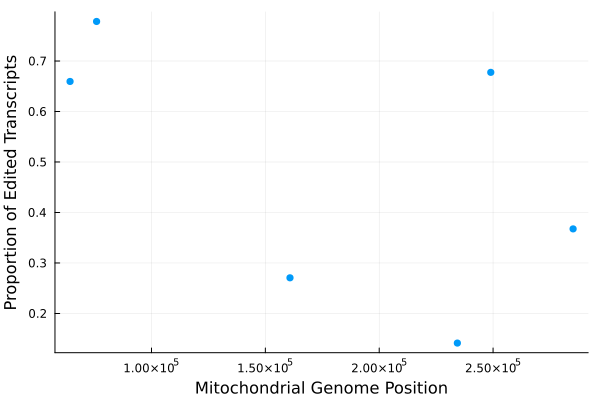

In [17]:
#make a scatter plot from the DataFrame containing allPh.fBH_1, allPh.fBH_2, allPh.fBH_3 (with a p-value less than 0.05). 
#The scatter plot will consist of position and proportion edited. 
#The ms (marker size), msw (marker stroke width) and alpha (softens colour) are set, there is no legend
# the x and y axes are defined as: x axis="genome position", y axis="proportion of edited transcripts"
editing_sites_binomial_plot = @df allPhb[(allPhb.bBH .< 0.05) .& (allPhb.bBH_1 .< 0.05) .& (allPhb.bBH_2 .< 0.05) .& (allPhb.bBH_3 .< 0.05),:]  scatter(:pos, :editp, ms=4, msw=0, alpha=2, legend=false, xguide="Mitochondrial Genome Position", yguide="Proportion of Edited Transcripts")

In [18]:
savefig("phylloglossum_UC_mitochondria.svg")

"C:\\Users\\20917397\\Desktop\\phylloglossum_editing\\Mitochondria_U-to-C_editing\\phylloglossum_UC_mitochondria.svg"

In [19]:
editing_sites_binomial = allPhb[(allPhb.bBH .< 0.05) .& (allPhb.bBH_1 .< 0.05) .& (allPhb.bBH_2 .< 0.05) .& (allPhb.bBH_3 .< 0.05),:] 

6×89 DataFrame
 Row │ refID                            pos     ref      fA     fC     fG     fU     rA     rC     rG     rU     f_total  r_total  edited  unedited  rsedited  rsunedited  total  rstotal  editp     rseditp  binomial     bBH          refID_1                          ref_1    fA_1   fC_1   fG_1   fU_1   rA_1   rC_1   rG_1   rU_1   f_total_1  r_total_1  edited_1  unedited_1  rsedited_1  rsunedited_1 ⋯
     │ String31                         Int64   String1  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64    Int64    Int64   Int64     Int64     Int64       Int64  Int64    Float64   Float64  Float64      Float64      String31                         String1  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64      Int64      Int64     Int64       Int64       Int64        ⋯
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Phylloglossum_drummondii_mt_1kb   64237  T            0    368      0    190      0      0      0      0      558        0     368       190         0           0    558        0  0.659498    NaN    0.0          0.0          Phylloglossum_drummondii_mt_1kb  T            0    440      0    276      0      0      0      0        716          0       440         276           0             0 ⋯
   2 │ Phylloglossum_drummondii_mt_1kb   75885  T            0   3462      0    986      3      0      0      0     4448        3    3462       986         0           3   4448        3  0.778327      0.0  0.0          0.0          Phylloglossum_drummondii_mt_1kb  T            0   2872      0   1026      1      0      0      0       3898          1      2872        1026           0             1
   3 │ Phylloglossum_drummondii_mt_1kb  160817  A            0      0      0      0      0     82      0    221        0      303      82       221         0           0    303        0  0.270627    NaN    1.00826e-36  7.39579e-33  Phylloglossum_drummondii_mt_1kb  A            0      0      0      0      0     57      0    245          0        302        57         245           0             0
   4 │ Phylloglossum_drummondii_mt_1kb  234319  A            1      0      0      0      0     27      0    164        1      191      27       164         0           1    191        1  0.141361      0.0  1.22691e-6   0.00642829   Phylloglossum_drummondii_mt_1kb  A            0      0      0      0      0     29      0    148          0        177        29         148           0             0
   5 │ Phylloglossum_drummondii_mt_1kb  248992  A            2      0      0      0      0    416      0    198        2      614     416       198         0           2    614        2  0.677524      0.0  0.0          0.0          Phylloglossum_drummondii_mt_1kb  A            1      0      0      0      0    512      0    231          1        743       512         231           0             1 ⋯
   6 │ Phylloglossum_drummondii_mt_1kb  285144  T            0   1097      0   1888      0      0      0      0     2985        0    1097      1888         0           0   2985        0  0.367504    NaN    0.0          0.0          Phylloglossum_drummondii_mt_1kb  T            0   1070      0   2299      1      0      0      0       3369          1      1070        2299           0             1
                                                                                                                                                                                                                                                                                                                                                                                              50

In [20]:
default(fontfamily="Helvetica")
@df allPhb[(allPhb.bBH .< 0.05) .& (allPhb.bBH_1 .< 0.05) .& (allPhb.bBH_2 .< 0.05) .& (allPhb.bBH_3 .< 0.05),:] plot(:pos, :f_total .+ :r_total .+ 1, yscale = :log10, ylims=(10, 1e7), size=(1000,400), xlabel="Phylloglossum drummondii Chloroplast Genome Position", ylabel="Read Depth", legend=false, margin=10mm)
@df editing_sites_binomial scatter!(twinx(), :pos, :editp, color=:green, ms=3, msw=0, alpha=:editp, ylabel="Proportion of Edited Transcripts", legend=false, margin=10mm)
savefig(first(split(basename("phyllo_mt_UC"), ".")) * ".svg")

"C:\\Users\\20917397\\Desktop\\phylloglossum_editing\\Mitochondria_U-to-C_editing\\phyllo_mt_UC.svg"

In [40]:
CSV.write("mt_UC_binomial.csv", editing_sites_binomial)

"mt_UC_binomial.csv"